<a href="https://colab.research.google.com/github/smartgrids-aau/GreenCodesPython/blob/main/Exemple_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Voltage-source inverter with Sinusoidal-Pulse Width Modulated output
By Tamer Khatib
 
The frequency of the output voltage, f = 50
The modulation index, ma (0 < ma < 1), ma = 0.2
The phase angle of the load in degrees = 25
The frequency of the carrier signal = 200
 
.................................................................
alpha        beta        width
39.600000   140.400000   100.800000
127.800000   232.200000   104.400000
219.600000   320.400000   100.800000


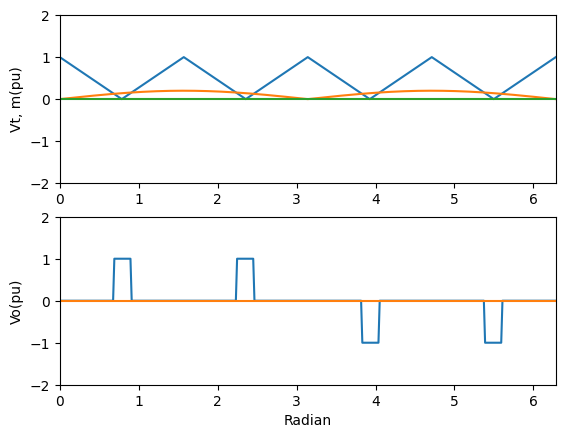

The RMS value of the output voltage = 
0.37416573867739417
The RMS value of the fundamental component = 
0.1408125345569391
The RMS value of the load current =
0.18594573462640085
The RMS value of the supply current is
0.09060278089803343
The Average value of the supply current is
0.029456017642918938
Performance parameters are
THD of output voltage:
2.4618411229274897
THD of output current:
0.8624016404221074


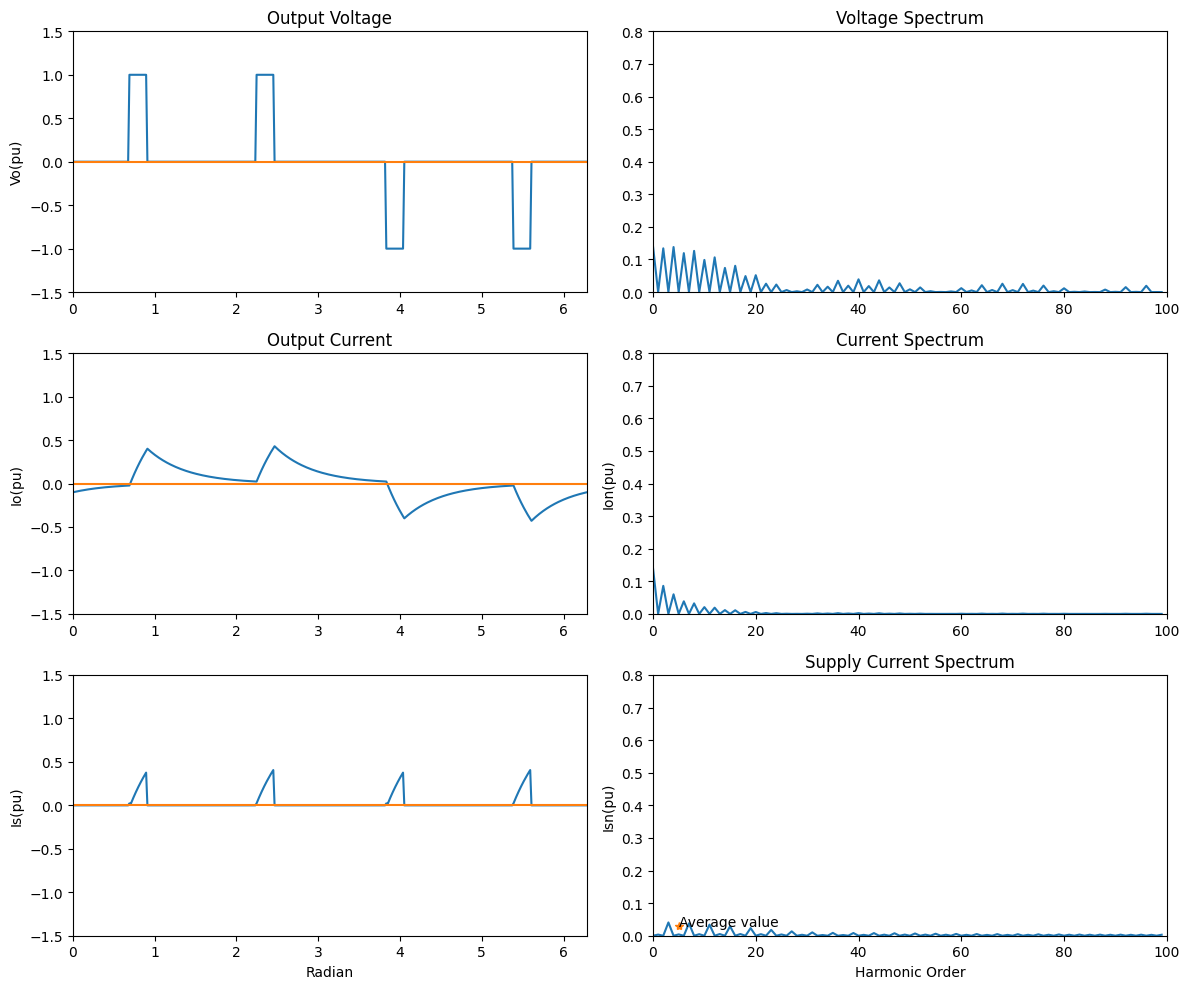

In [15]:
# Example 3.3

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

def main():
    # PART I: Preparation
    print('Voltage-source inverter with Sinusoidal-Pulse Width Modulated output')
    print('By Tamer Khatib')
    print(' ')

    # PART II: Input Parameters
    Vrin = 1  # DC input voltage
    f = float(input('The frequency of the output voltage, f = '))
    Z = 1     # Load impedance (per unit)
    ma = float(input('The modulation index, ma (0 < ma < 1), ma = '))
    phi = float(input('The phase angle of the load in degrees = '))
    fc = float(input('The frequency of the carrier signal = '))

    # PART III: Load Parameters
    phi = phi * np.pi / 180
    R = Z * np.cos(phi)
    L = (Z * np.sin(phi)) / (2 * np.pi * f)

    # PART IV: Number of Pulses
    N = int(fc / f)

    # Initialize arrays
    wt = np.zeros(2*N*50)
    ma1 = np.zeros(2*N*50)
    Vt = np.zeros(2*N*50)
    Vout = np.zeros(2*N*50)
    alpha = []
    beta = []

    # PART V: Generate Sawtooth & PWM Waveform
    for k in range(1, 2*N+1):
        for j in range(1, 51):
            i = j + (k-1)*50 - 1  # Convert to 0-based indexing
            wt[i] = (j + (k-1)*50) * np.pi / (N * 50)

            # Determine positive/negative half
            hpf = np.sign(np.sin(wt[i]))
            if hpf == 0:
                hpf = 1

            ma1[i] = ma * abs(np.sin(wt[i]))

            if k % 2 == 0:  # Even -> increasing
                Vt[i] = 0.02 * j
                if abs(Vt[i] - ma * abs(np.sin(wt[i]))) <= 0.011:
                    m = j
                    beta.append(3.6 * ((k-1)*50 + m) / N)
            else:  # Odd -> decreasing
                Vt[i] = 1 - 0.02 * j
                if abs(Vt[i] - ma * abs(np.sin(wt[i]))) < 0.011:
                    l = j
                    alpha.append(3.6 * ((k-1)*50 + l) / N)

            # Output voltage
            if Vt[i] > ma * abs(np.sin(wt[i])):
                Vout[i] = 0
            else:
                Vout[i] = hpf * Vrin

    # Remove first element from beta (equivalent to beta(1) = [] in MATLAB)
    if beta:
        beta = beta[1:]

    # Convert to numpy arrays
    alpha = np.array(alpha)
    beta = np.array(beta)

    # PART VI: Pulse Timing Table
    print(' ')
    print('.................................................................')
    print('alpha        beta        width')
    for i in range(min(len(alpha), len(beta))):
        print(f'{alpha[i]:.6f}   {beta[i]:.6f}   {beta[i] - alpha[i]:.6f}')

    # PART VII: Plotting PWM Waveforms
    a = np.zeros_like(wt)
    plt.figure(1)
    plt.subplot(2, 1, 1)
    plt.plot(wt, Vt, wt, ma1, wt, a)
    plt.axis([0, 2*np.pi, -2, 2])
    plt.ylabel('Vt, m(pu)')

    plt.subplot(2, 1, 2)
    plt.plot(wt, Vout, wt, a)
    plt.axis([0, 2*np.pi, -2, 2])
    plt.ylabel('Vo(pu)')
    plt.xlabel('Radian')
    plt.show()

    # PART VIII: Output Voltage Analysis
    Vo = np.sqrt(np.mean(Vout**2))
    print('The RMS value of the output voltage = ')
    print(Vo)

    y = fft(Vout)
    y = y[1:]  # Remove first element
    x = np.abs(y)
    x = (np.sqrt(2) / len(Vout)) * x
    print('The RMS value of the fundamental component = ')
    print(x[0])

    THDVo = np.sqrt(Vo**2 - x[0]**2) / x[0]

    # PART IX: Output Current Calculation
    m = R / (2 * np.pi * f * L)
    DT = np.pi / (N * 50)
    C = np.zeros(2000*N)
    C[0] = -10

    # Extend Vout array
    Vout_extended = np.zeros(2000*N)
    Vout_extended[:len(Vout)] = Vout

    for i in range(100*N, 2000*N):
        Vout_extended[i] = Vout_extended[i - 100*N]

    for i in range(1, 2000*N):
        C[i] = C[i-1] * np.exp(-m * DT) + Vout_extended[i-1] / R * (1 - np.exp(-m * DT))

    # PART X: Output Current Analysis
    CO = np.zeros(100*N)
    for j4 in range(100*N):
        CO[j4] = C[j4 + 1900*N]

    CO2 = fft(CO)
    CO2 = CO2[1:]  # Remove first element
    COX = np.abs(CO2)
    COX = (np.sqrt(2) / (100*N)) * COX

    CORMS = np.sqrt(np.mean(CO**2))
    print('The RMS value of the load current =')
    print(CORMS)

    THDIo = np.sqrt(CORMS**2 - COX[0]**2) / COX[0]

    # PART XI: Supply Current Waveform
    CS = np.zeros(2000*N)
    for j2 in range(1900*N, 2000*N):
        if Vout_extended[j2] != 0:
            CS[j2] = abs(C[j2])
        else:
            CS[j2] = 0

    # PART XII: Supply Current Analysis
    CS1 = np.zeros(100*N)
    for j3 in range(100*N):
        CS1[j3] = abs(CS[j3 + 1900*N])

    CSRMS = np.sqrt(np.mean(CS1**2))
    print('The RMS value of the supply current is')
    print(CSRMS)

    CSAV = np.mean(CS1)
    print('The Average value of the supply current is')
    print(CSAV)

    CS2 = fft(CS1)
    CS2 = CS2[1:]
    CSX = np.abs(CS2)
    CSX = (np.sqrt(2) / (100*N)) * CSX

    # PART XIII: Display Performance Parameters
    print('Performance parameters are')
    print('THD of output voltage:')
    print(THDVo)
    print('THD of output current:')
    print(THDIo)

    # PART XIV: Plot All Results
    plt.figure(2, figsize=(12, 10))

    plt.subplot(3, 2, 1)
    plt.plot(wt, Vout[:100*N], wt, a[:100*N])
    plt.title('Output Voltage')
    plt.axis([0, 2*np.pi, -1.5, 1.5])
    plt.ylabel('Vo(pu)')

    plt.subplot(3, 2, 2)
    plt.plot(x[:100])
    plt.title('Voltage Spectrum')
    plt.axis([0, 100, 0, 0.8])

    plt.subplot(3, 2, 3)
    plt.plot(wt, C[1900*N:2000*N], wt, a[:100*N])
    plt.title('Output Current')
    plt.axis([0, 2*np.pi, -1.5, 1.5])
    plt.ylabel('Io(pu)')

    plt.subplot(3, 2, 4)
    plt.plot(COX[:100])
    plt.title('Current Spectrum')
    plt.axis([0, 100, 0, 0.8])
    plt.ylabel('Ion(pu)')

    plt.subplot(3, 2, 5)
    plt.plot(wt, CS[1900*N:2000*N], wt, a[:100*N])
    plt.axis([0, 2*np.pi, -1.5, 1.5])
    plt.ylabel('Is(pu)')
    plt.xlabel('Radian')

    plt.subplot(3, 2, 6)
    plt.plot(CSX[:100])
    plt.plot(5, CSAV, '*')
    plt.text(5, CSAV, 'Average value')
    plt.title('Supply Current Spectrum')
    plt.axis([0, 100, 0, 0.8])
    plt.ylabel('Isn(pu)')
    plt.xlabel('Harmonic Order')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
